# 1. Load modules

In [1]:
%matplotlib widget 
#%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
import matplotlib.ticker as ticker
from scipy import optimize
import os, sys
from pathlib import Path
import xrdpy

# 2. Set up the xrd-file path

In [2]:
xrdpy_test_path = Path().absolute()

In [3]:
filepath = os.path.join(xrdpy_test_path,"xrd_files")
filename = "NT3285_RSM_w-2T_105AlGaN_calibration_fine.xrdml"

In [4]:
savefig = True
save_fig_path = os.path.join(xrdpy_test_path,"../imgs")

In [5]:
gen_fns = xrdpy.general_fns(print_log='low')
xrd_ = xrdpy.xrd(print_log='low')
xrd_plt = xrdpy.plottings(save_figure_dir=save_fig_path, print_log='low')

# 3. Set default variables

#### Variable source: https://www.ioffe.ru/SVA/NSM/Semicond/

In [6]:
alloy_type='ternary' 
structure_type='wz'

# Lattice parameters for AlN and GaN binaries
AlN_a, AlN_c = 3.112, 4.982
GaN_a, GaN_c = 3.189, 5.185    

# Cij parameters for AlN and GaN binaries
GaN_C13 = 106
GaN_C33 = 398
AlN_C13 = 108
AlN_C33 = 373

# Bowing parameters
bowing_a = 0.0
bowing_c = 0.0
bowing_C13 = 0.0
bowing_C33 = 0.0

# reciprocal axes are multiplited by this number to make enlarge axes
mul_fact = [10000, 10000] # along [Qx, Qy]

# a_lp_bin: [a_lattice_parameter bin_1, a_lattice_parameter bin_2, bowing]
# For ternary_wz we need followings: [a_lp_bin, c_lp_bin, c13_bin, c33_bin]
# Alloy_params = x*list_binary_parameters[i][0] + (1-x)*list_binary_parameters[i][1]+bowing*x*1-x
# WARNING: Maintain the order of data given for material parameters for all list below. 
# E.g. Do not do like [[AlN_data, GaN_data, bowing],[GaN_data, AlN_data, bowing],...]
list_binary_parameters = [[AlN_a, GaN_a, bowing_a], [AlN_c, GaN_c, bowing_c],
                          [AlN_C13, GaN_C13, bowing_C13], [AlN_C33, GaN_C33, bowing_C33]]

# Reflection plane hkl
hkl = (1,0,5)

# 4. Read xrd-file

## 4.1 Real space data

In [7]:
lambda_wavelength, two_theta_values, omega_values, rsm_intesity  = \
    xrd_.xrd_read_data(xrd_file_name=os.path.join(filepath, filename))
# X-ray wave number
R = 1/lambda_wavelength

Wavelength used (from xrd file): 1.5405980
Intensity unit (from xrd file): counts/seconds


## 4.2 Reciprocal space conversion

In [8]:
total_two_theta_in_row = np.shape(rsm_intesity)[1]
rec_space_x, rec_space_y = xrd_.Qxy(omega=omega_values, two_theta=two_theta_values, 
                                    total_two_theta_in_row=total_two_theta_in_row,
                                    R=R, mul_fact=mul_fact)

# 5. Perform post-calculations from maps

## 5.1 Find peaks before shift

In [9]:
_, peaks_x, peaks_y, peaks_z = xrd_.find_peaks(rec_space_x, rec_space_y, rsm_intesity,
                                               apply_filter=True, threshold=100,
                                               sigma=1, filter_type='gaussian')

In [10]:
print(f'Peaks x-coord: {peaks_x}\nPeaks y-coord: {peaks_y}\nPeaks intensities: {peaks_z}')

Peaks x-coord: [3770.7147201  3772.78904992 3773.61709504 3774.66367725 3775.9373537
 3775.33155708 3776.83144145 3776.74373393]
Peaks y-coord: [ 9850.99308842  9897.30672175  9914.89420765  9946.0223383
  9957.14520591  9973.7086386  10006.33838239 10019.18401303]
Peaks intensities: [1962.77278562 2012.83697047 2103.97946085 1775.35301669 1801.02695764
 1708.60077022  344.03080873 3379.97432606]


## 5.2 Plot before shift

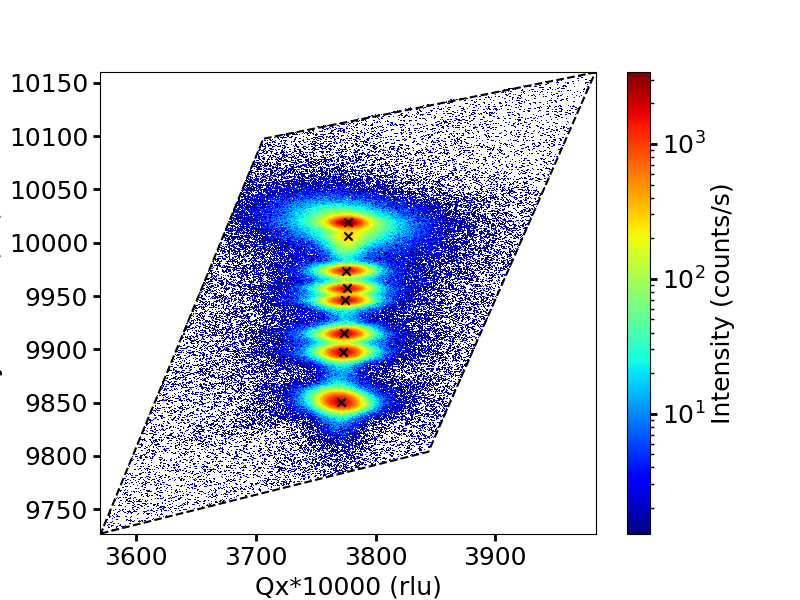

In [11]:
xlabel_text = f'Qx*{mul_fact[0]} (rlu)'
ylabel_text = f'Qy*{mul_fact[1]} (rlu)'
save_file_name = None

#====================== Plot the map =================================
fig, ax, _ = xrd_plt.xrd_plot(show_plot=False, save_file_name=None, x_values=rec_space_x, 
                              y_values=rec_space_y, z_values=rsm_intesity,
                              mode="reciprocal_space", xaxis_label=xlabel_text,
                              yaxis_label=ylabel_text, color_map='jet', color_scale='log',
                              colorbar_label='Intensity (counts/s)')
ax.scatter(peaks_x, peaks_y, marker='x', color='k')

## 5.3 Shift experimental image to align with theoretical reference 

### 5.3.1 Calculate reference point theoretically

In [12]:
# Calculating only for AlN as this is my reference point
rec_space_theor_ref_xy = xrd_.Qxy_theor(AlN_a, AlN_c, hkl=hkl, structure_type=structure_type) 
print(f'Theoretically calculated reference points: {rec_space_theor_ref_xy}')

Theoretically calculated reference points: (3710.477308416618, 10036.130068245684)


### 5.3.2 Get or define the reference point in data
##### E.g. Here we use the highest maximum point as reference (AlN). This will be used as full strain line reference. You use the above figure to decide which point to use as reference.

In [13]:
x_coord_max = peaks_x[-1] 
y_coord_max = peaks_y[-1] 
print(f'Reference experimental peak/point (before shift): {x_coord_max}, {y_coord_max}')

Reference experimental peak/point (before shift): 3776.7437339265052, 10019.184013026219


### 5.3.3 Calculate shift required to map experimental referernce on theoretically calculated reference

In [14]:
# Calcuate shift amount
shift_xy_ = np.array([rec_space_theor_ref_xy[0]-x_coord_max, rec_space_theor_ref_xy[1]-y_coord_max])
print(f'Shift of refence peak: {shift_xy_}')

Shift of refence peak: [-66.26642551  16.94605522]


### 5.3.4 Shift experimental data

In [15]:
rec_space_x_shift = rec_space_x + shift_xy_[0]  # Shifting x-coordinates
rec_space_y_shift = rec_space_y + shift_xy_[1]  #shifting y-coordinates
# Add the shift to reference peak in experimental data
reference_peak = [x_coord_max+shift_xy_[0], y_coord_max+shift_xy_[1]]
print(f'Reference experimental peak/point (after shift): {reference_peak}')

Reference experimental peak/point (after shift): [3710.477308416618, 10036.130068245684]


## 5.4. Find the peak positions after shift

In [16]:
rsm_intesity_filter, peaks_x, peaks_y, peaks_z = xrd_.find_peaks(rec_space_x_shift, rec_space_y_shift, rsm_intesity, 
                                                                 apply_filter=True, threshold=100, 
                                                                 sigma=1, filter_type='gaussian')

In [17]:
print(f'Peaks x-coord: {peaks_x}\nPeaks y-coord: {peaks_y}\nPeaks intensities: {peaks_z}')

Peaks x-coord: [3704.44829459 3706.52262441 3707.35066953 3708.39725174 3709.67092819
 3709.06513157 3710.56501594 3710.47730842]
Peaks y-coord: [ 9867.93914364  9914.25277697  9931.84026287  9962.96839352
  9974.09126113  9990.65469382 10023.28443761 10036.13006825]
Peaks intensities: [1962.77278562 2012.83697047 2103.97946085 1775.35301669 1801.02695764
 1708.60077022  344.03080873 3379.97432606]


# 6. Plottings

In [18]:
xlabel_text = f'Qx*{mul_fact[0]} (rlu)'
ylabel_text = f'Qy*{mul_fact[1]} (rlu)'
save_file_name = 'AlN_AlGaN_AlN_peaks.png' if savefig else None
color_map='jet'

#====================== Plot the map =================================
fig, axs = plt.subplots(1, 2, figsize=(14,6), sharey=True, sharex=True,constrained_layout=True)
_ = xrd_plt.xrd_plot(fig=fig, ax=axs[0],save_file_name=None, x_values=rec_space_x_shift, 
                              y_values=rec_space_y_shift, z_values=rsm_intesity,vmin=1,
                              mode="reciprocal_space", xaxis_label=xlabel_text, show_colorbar=False,
                              yaxis_label=ylabel_text, color_map=color_map, color_scale='log',
                              show_plot=False, title_text='original')
_ = xrd_plt.xrd_plot(fig=fig, ax=axs[1],save_file_name=None, x_values=rec_space_x_shift, vmin=1,
                              y_values=rec_space_y_shift, z_values=rsm_intesity_filter, threshold_intensity=0.2,
                              mode="reciprocal_space", xaxis_label=xlabel_text, show_contours=False,
                              yaxis_label='',color_map=color_map, color_scale='log',show_plot=False,
                              colorbar_label='Intensity (counts/s)', title_text='smooth')
axs[0].scatter(peaks_x, peaks_y, marker='x', color='k')
axs[1].scatter(peaks_x, peaks_y, marker='x', color='k')

if savefig:
    xrd_plt.save_figure(save_file_name, fig=fig, dpi=75)
    plt.close()